**Лекция 8**

# Регрессия на основе гауссовских процессов

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Непараметрическая-регрессия" data-toc-modified-id="Непараметрическая-регрессия-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Непараметрическая регрессия</a></span></li><li><span><a href="#Регрессия-на-основе-гауссовских-процессов" data-toc-modified-id="Регрессия-на-основе-гауссовских-процессов-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Регрессия на основе гауссовских процессов</a></span><ul class="toc-item"><li><span><a href="#Формулы" data-toc-modified-id="Формулы-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Формулы</a></span></li><li><span><a href="#Реализация" data-toc-modified-id="Реализация-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Реализация</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#Обучающая-выборка-без-шума-(интерполяция)" data-toc-modified-id="Обучающая-выборка-без-шума-(интерполяция)-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Обучающая выборка без шума (интерполяция)</a></span></li><li><span><a href="#Обучающая-выборка-с-шумом-(аппроксимация)" data-toc-modified-id="Обучающая-выборка-с-шумом-(аппроксимация)-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Обучающая выборка с шумом (аппроксимация)</a></span></li></ul></li><li><span><a href="#Источники" data-toc-modified-id="Источники-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Источники</a></span></li></ul></div>

In [1]:
# Imports
import numpy as np
np.random.seed(42)

import sys
sys.path.append('./scripts')
import GP_kernels
from GP_utils import plot_GP

In [2]:
# Styles, fonts
import matplotlib
matplotlib.rcParams['font.size'] = 12
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import cm # Colormaps

import seaborn
seaborn.set_style('whitegrid')

In [3]:
# %config InlineBackend.figure_formats = ['pdf']
# %config Completer.use_jedi = False

---

##  Непараметрическая регрессия

В методах обучения с учителем мы часто используем *параметрические модели* $p(\mathbf{y} \lvert \mathbf{X},\boldsymbol\theta)$ для аппроксимации данных и нахождения оптимальных значений параметра $\boldsymbol\theta$ с помощью метода максимального правдоподобия или метода оценки апостериорного максимума.
С ростом сложности данных для построения хорошей аппроксимации обычно требуются модели с большим количеством параметров.
Методы, использующие модели с фиксированным количеством параметров, называются параметрическими методами.

Другим подходом является использование *непараметрических методов*, где количество параметров зависит от размера набора данных.
Например, в ядерной регрессии Надарая&ndash;Ватсона каждому наблюдаемому отклику $y_i$ присваивается вес $w_i$, а для предсказания целевого значения в новой точке $\mathbf{x}$ вычисляется средневзвешенное значение: 
$$
  f(x) = \frac{\sum_{i=1}^{N} k(x, x_i) y_i} {\sum_{i=1}^{N} k(x, x_i)}.
$$

Эта формула интуитивно очевидна: значение $f(x)$ есть взвешенное среднее $y_i$ по объектам $x_i$, причём чем ближе объекты к $x$, тем больше их вес.
Веса зависят от $x$ и наблюдаемых $x_i$, а функция зависимости $k(x, x_i)$ называется *ядром*.

In [4]:
# Data
xlim = [0., 10.]
N_test = 101
X_test = np.linspace(*xlim, N_test).reshape(-1, 1)

X_train = np.array([2.,  6.,  7., 8.,  4., 3. ]).reshape(-1, 1)
Y_train = np.array([1., -1., -1., 0.5, 1., 0.5]).reshape(-1, 1)

In [5]:
def NW_predictor(X_test, X_train, Y_train, kernel_fun, kernel_args):
    ''''''
    K = kernel_fun(X_test, X_train, kernel_args)
    Weights = K / K.sum(axis=1).reshape(-1, 1)
    return Weights @ Y_train

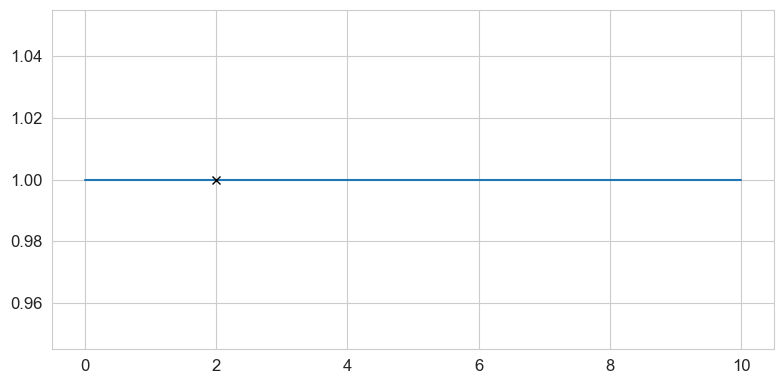

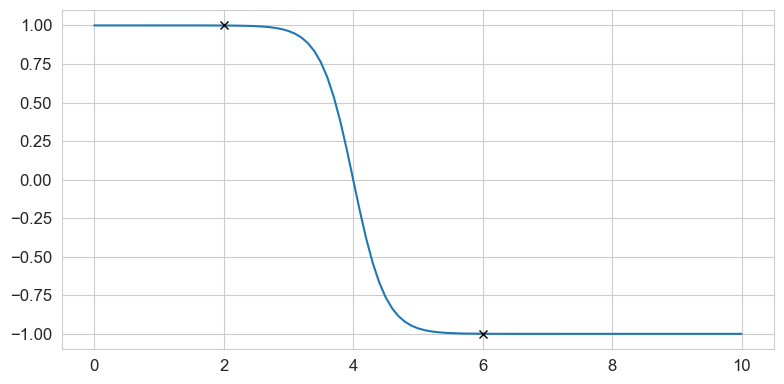

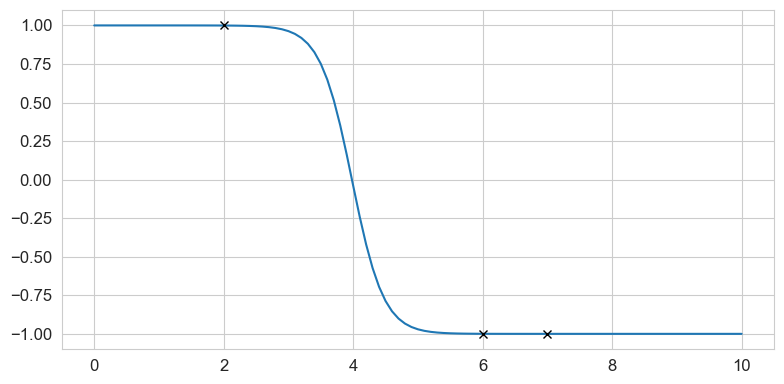

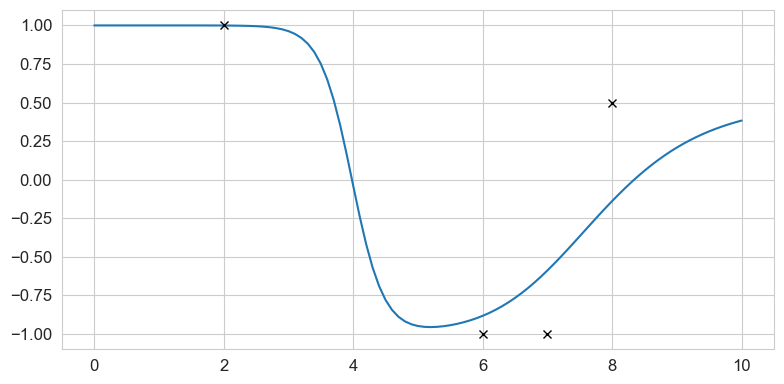

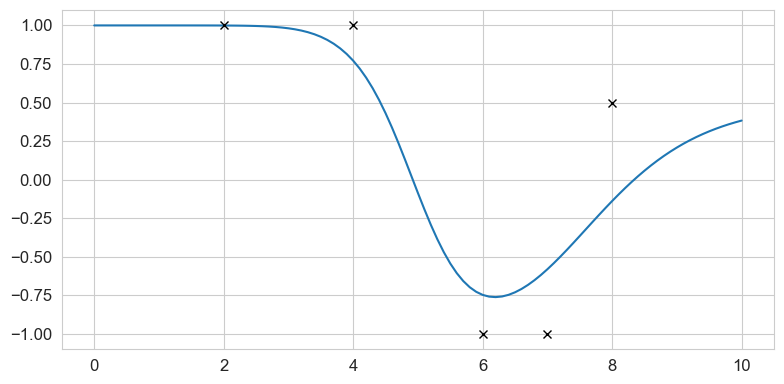

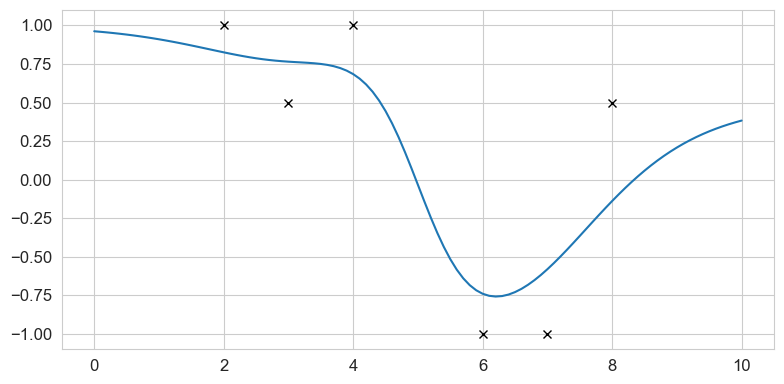

In [6]:
for i, _ in enumerate(X_train, start=1):
    x_train_i = X_train[:i]
    y_train_i = Y_train[:i]
    
    # Compute mean and covariance of the posterior predictive distribution
    kernel_fun = GP_kernels.gauss
    kernel_args = {'l':1.}
    Y_test = NW_predictor(X_test, x_train_i, y_train_i, kernel_fun, kernel_args)
    
    # Draw samples from the prior
    plt.figure(figsize=(8, 4))
    plt.plot(X_test, Y_test)
    plt.plot(x_train_i, y_train_i, 'kx')
    plt.tight_layout()
    plt.show()

Примером является метод KNN (k-nearest neighbors), где $k$ самых близких наблюдений имеют вес $1/k$, а все остальные &mdash; $0$.
Обычно, для вычисления прогноза непараметрические методы должны обработать все обучающие данные и поэтому работают медленнее, чем параметрические методы.
Зато само обучение обычно происходит быстро, так как непараметрическим моделям нужно только запомнить обучающие данные.

Ещё одним примером непараметрического метода являются гауссовские процессы. Поскольку гауссовские процессы моделируют распределение функций, мы можем использовать их для построения регрессионных моделей.

---

## Регрессия на основе гауссовских процессов

В регрессии на основе гауссовских процессов предполагается, что заданная выборка значений целевой функции является реализацией гауссовского процесса и ковариационная функция процесса зависит только от взаимного расположения точек в пространстве.
Апостериорное среднее гауссовского процесса в новой точке используется для прогноза целевой функции в данной точке, а апостериорная дисперсия используется в качестве оценки неопределённости этого прогноза.

Обычно предполагают, что ковариационная функция гауссовского процесса лежит в параметрическом семействе.
Тогда задание регрессионной модели эквивалентно выбору параметров ковариационной функции.
Для оценки параметров используют метод максимального правдоподобия и байесовские методы.

### Формулы

Вспомним выражения для условного (апостериорного) распределения Гаусса. 

Итак, мы хотим сделать прогноз $y_2 = f(X_2)$ для $n_2$ новых объектов, основываясь на $n_1$ ранее наблюдаемых объектах $(X_1,y_1)$.
Это можно сделать с помощью апостериорного распределения $p(y_2 \mid y_1, X_1, X_2)$.
Предполагая, что $y_1$ и $y_2$ имеют совместное нормальное распределение, мы можем написать:
$$
\left[\begin{array}{c} \mathbf{y}_{1} \\ \mathbf{y}_{2} \end{array}\right]
\sim
\mathcal{N} \left(
\left[\begin{array}{c} \mu_{1} \\ \mu_{2} \end{array}\right],
\left[ \begin{array}{cc}
\Sigma_{11} & \Sigma_{12} \\
\Sigma_{21} & \Sigma_{22}
\end{array} \right]
\right).
$$

Здесь:
$$
\begin{split}
  \mu_{1}     &= m(X_1)     \quad & (n_1 \times 1),   \\
  \mu_{2}     &= m(X_2)     \quad & (n_2 \times 1),   \\
  \Sigma_{11} &= k(X_1,X_1) \quad & (n_1 \times n_1), \\
  \Sigma_{22} &= k(X_2,X_2) \quad & (n_2 \times n_2), \\
  \Sigma_{12} &= k(X_1,X_2) \quad & (n_1 \times n_2), \\
  \Sigma_{21} &= k(X_2,X_1) \quad & (n_2 \times n_1).
\end{split}
$$

Для простоты положим $\mu_{1} = 0$ и $\mu_{2} = 0$.
Тогда для апостериорного распределения получим
$$
  p(y_2 \mid y_1) = \mathcal{N}(\mu_{2|1}, \Sigma_{2|1}),
$$
где
$$
\begin{split}
    \mu_{2|1}    &= \Sigma_{21} \Sigma_{11}^{-1} y_1, \\
    \Sigma_{2|1} &= \Sigma_{22} - \Sigma_{21} \Sigma_{11}^{-1}\Sigma_{12}.
\end{split}
$$

Теперь мы можем предсказать $y_2$, используя апостериорное среднее $\mu_{2|1}$ в качестве прогноза. 
Обратим внимание, что кривая регрессии $\mu_{2|1}$ является суммой с весами наблюдаемых значений $y_1$, где веса вычисляются с помощью ковариационной функции $k$.
Оценить точность прогноза можно с помощью значений дисперсии $\sigma_2^2$, стоящих на диагонали апостериорной ковариационной матрицы $\Sigma_{2|1}$.

### Реализация

Во-первых, заметим, что выражения для апостериорного математического ожидания и апостериорной ковариационной матрицы можно записать в более адаптированном к вычислениям виде:
$$
\begin{split}
    \mu_{2|1}    &\;= (\Sigma_{11}^{-1}\Sigma_{12})^\top  y_1, \\
    \Sigma_{2|1} &\;= \Sigma_{22} - (\Sigma_{11}^{-1}\Sigma_{12})^\top  \Sigma_{12}.
\end{split}
$$

Мы будем использовать процессы с квадратичным экспоненциальным ядром:
$$
  k(x, x') = \sigma_k^2 \exp{ \left( -\frac{\lVert x - x' \rVert^2}{2\ell^2}  \right) }.
$$

Ниже приводится функция `GP_predictor()`, которая делают всю работу.
Матрица $\Sigma_{11}^{-1}\Sigma_{12}$ вычисляется с помощью функции `numpy.linalg.solve()`.

In [7]:
def GP_predictor(X_test, X_train, Y_train,
                 kernel_fun, kernel_args, sigma_n=1e-8):
    '''
    Computes the suffiсient statistics of the GP posterior predictive distribution 
    from m training data X_train and Y_train and n new inputs X_test.
    
    Args:
        X_test:      New input locations (n x d)
        X_train:     Training locations  (m x d)
        Y_train:     Training targets    (m x 1)
        kernel_fun:  Kernel function
        kernel_args: Kernel parameters: length and vertical variation
        sigma_n:     Noise parameter
    
    Returns:
        Posterior mean vector (n x d) and covariance matrix (n x n)
    '''
    
    K_11 = kernel_fun(X_train, X_train, kernel_args) \
         + sigma_n*np.eye(len(X_train))
    K_12 = kernel_fun(X_train, X_test, kernel_args)
    K_solved = np.linalg.solve(K_11, K_12).T
    K_22 = kernel_fun(X_test,  X_test, kernel_args)
    
    mu  = K_solved @ Y_train
    cov = K_22 - K_solved @ K_12
    
    return mu, cov

---

## Тестирование

### Обучающая выборка без шума (интерполяция)

Приведенный ниже код вычисляет апостериорное распределение при заданной обучающей выборке.
Результаты представлены ниже.
Чёрным цветом показана линия регрессии &mdash; функция апостериорного среднего $\mu_{2|1}(x)$.
Разноцветные линии &mdash; примеры траекторий процесса.
На рисунках видно, что точки обучающей выборки как будто захватывают траектории процесса в узкие пучки.

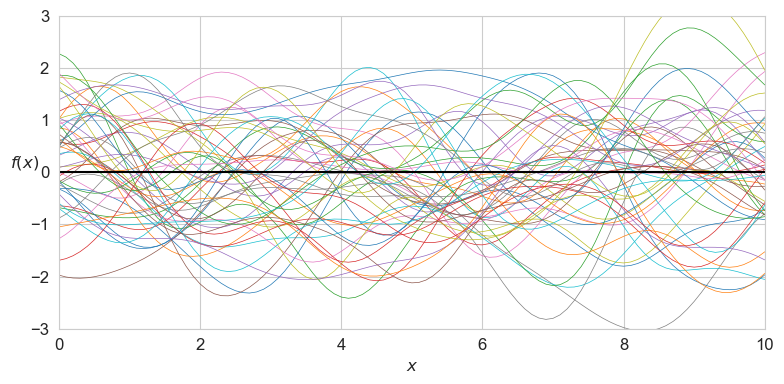

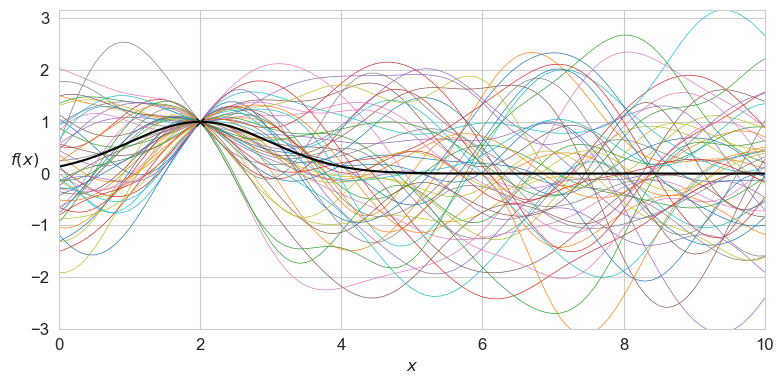

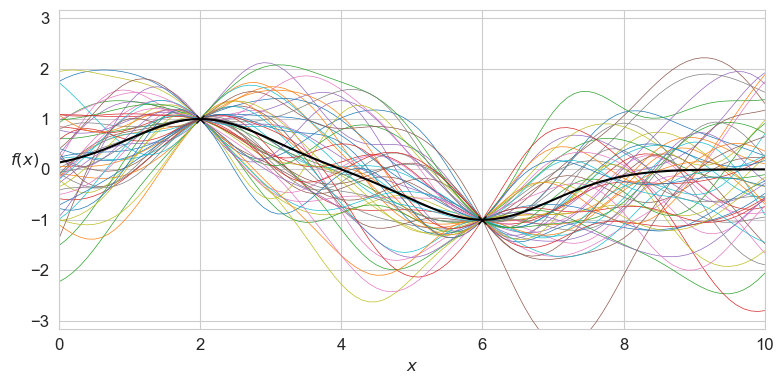

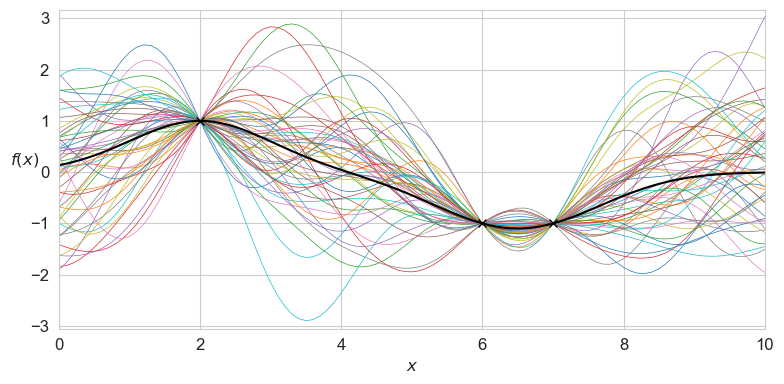

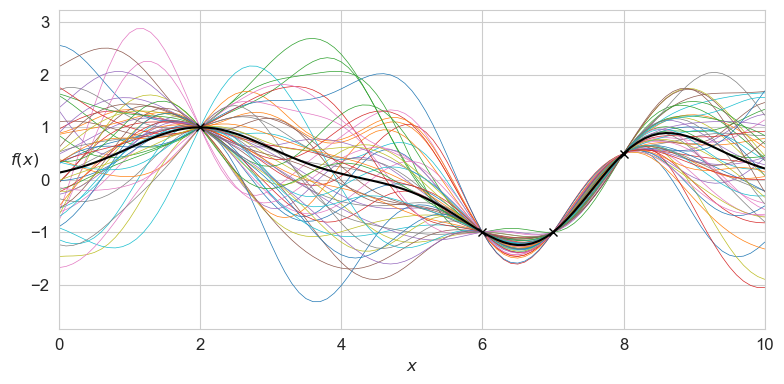

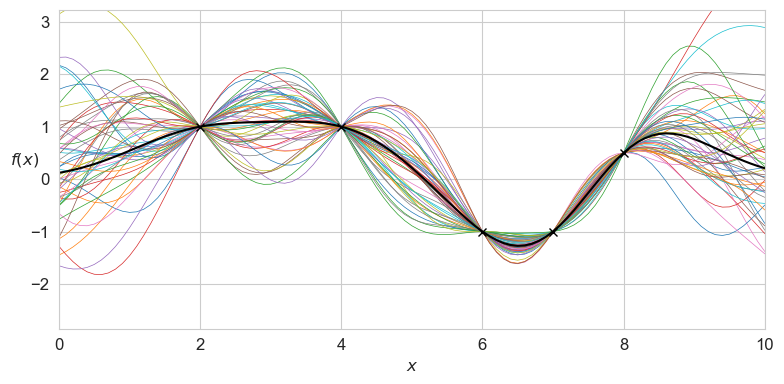

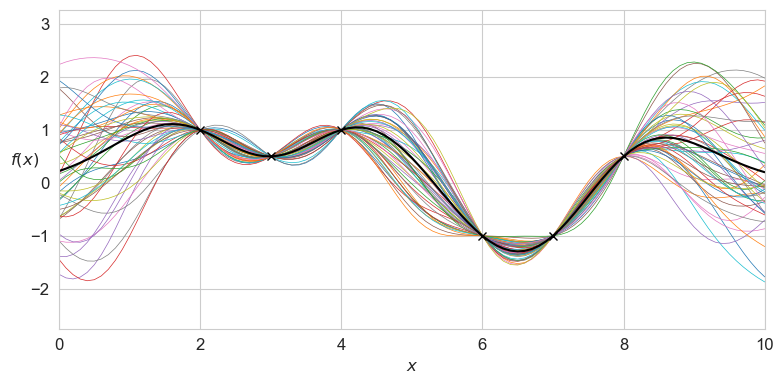

In [8]:
N_gp_post = 50

for i in range(len(X_train)+1):
    x_train_i = X_train[:i]
    y_train_i = Y_train[:i]
    
    # Compute mean and covariance of the posterior predictive distribution
    kernel_fun = GP_kernels.gauss
    kernel_args = {'l':1.}
    mu, cov = GP_predictor(X_test, x_train_i, y_train_i,
                           kernel_fun, kernel_args)
    # Generate samples from the prior
    gp_post = np.random.multivariate_normal(mu.flatten(), cov, N_gp_post).T
    
    # Draw samples from the prior
    plt.figure(figsize=(8, 4))
    plot_GP(X_test, mu, cov, x_train_i, y_train_i, gp_post)
    plt.tight_layout()
    plt.show()

Получим выражения для первых двух регрессионных кривых в явном виде:

1. $f(x | x_1, y_1) = y_1 \cdot e^{-\frac{1}{2}(x-x_1)^2} = e^{-\frac{1}{2}(x-2)^2}$
2. учитывая, что $k_{12} = e^{-\frac{1}{2}(x_2 - x_1)^2} = e^{-\frac{1}{2}(6 - 2)^2} = 3.4 \cdot 10^{-4} \approx 0$,  
получим $f(x | x_1, y_1, x_2, y_2) \approx y_1 \cdot e^{-\frac{1}{2}(x-x_1)^2} + y_2 \cdot e^{-\frac{1}{2}(x-x_2)^2} = e^{-\frac{1}{2}(x-2)^2} - e^{-\frac{1}{2}(x-6)^2}$

В завершение приведём последний рисунок ещё раз, но уже без траекторий процесса.
Серым цветом показана оценка неопределённости прогноза регрессии: два среднеквадратичных отклонения $\sigma_{2|1}(x)$ в обе стороны.
Значения $\sigma_{2|1}(x)$ вычисляются как корни из диагональных элементов апостериорной ковариационной матрицы $\Sigma_{2|1}$.
Отметим, что неопределённость прогноза равна нулю в точках обучающей выборки и возрастает по мере удаления от этих точек.

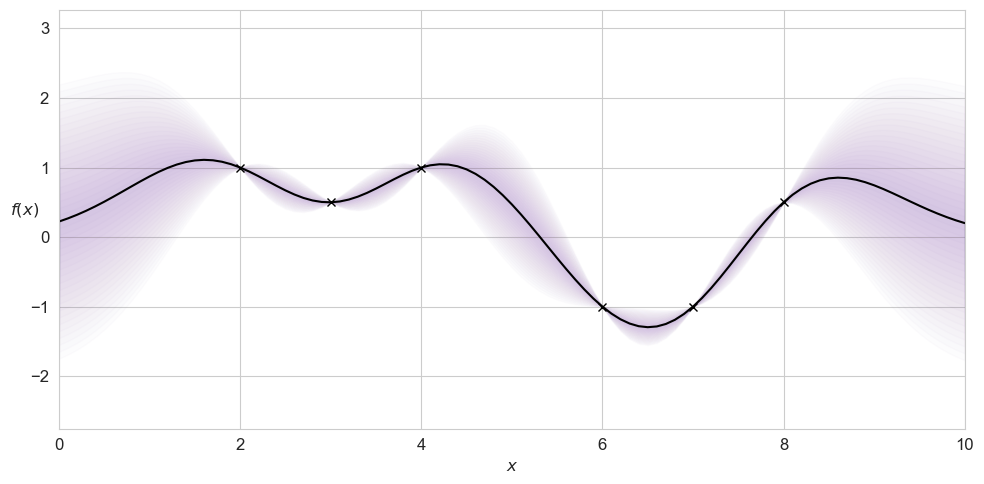

In [9]:
# Compute mean and covariance of the posterior predictive distribution
kernel_fun = GP_kernels.gauss
kernel_args = {'l':1.}
mu, cov = GP_predictor(X_test, X_train, Y_train,
                       kernel_fun, kernel_args)
# Generate samples from the prior
gp_post = np.random.multivariate_normal(mu.flatten(), cov, N_gp_post).T
    
# Draw samples from the prior
plt.figure(figsize=(10, 5))
plot_GP(X_test, mu, cov, X_train, Y_train, draw_ci=True)
plt.tight_layout()
plt.show()

### Обучающая выборка с шумом (аппроксимация)

Построенная регрессия предполагает, что обучающие данные $f(X_1) = \mathbf{y}_1$ абсолютно точны.
Это можно заметить на приведенном выше графике, так как в точках обучающей выборки $(X_1,\mathbf{y}_1)$ апостериорная дисперсия становится равной нулю.

А что, если мы не на 100 % уверены в обучающих данных?
То есть значения, через которые мы проводим процесс, измерены с какой-то точностью.
В таком случае можно делать прогноз по шумным наблюдениям $f(X_1) = \mathbf{y}_1 + \varepsilon$, смоделировав шум с помощью нормальной случайной величиной нулевым математическим ожиданием и дисперсией $\sigma_n$: $\varepsilon \sim \mathcal{N}(0, \sigma_n^2)$.
Это можно сделать, добавив диагональную матрицу к ковариационному ядру наших наблюдений (вспоминаем гребневую регрессию):
$$
  \Sigma_{11} = k(X_1,X_1) + \sigma_n^2 I.
$$
Отметим, что шум изменяет только диагональные элементы ядра (белый шум некоррелирован).

Приведённый ниже код строит регрессию не тех же обучающих данных, но в этот раз с добавлением шума.
На рисунках видно, что дисперсия $\sigma_{2|1}^2$ в точках обучающей выборки больше не равна 0, а линия регрессии и траектории процесса больше не обязаны проходить через эти точки.

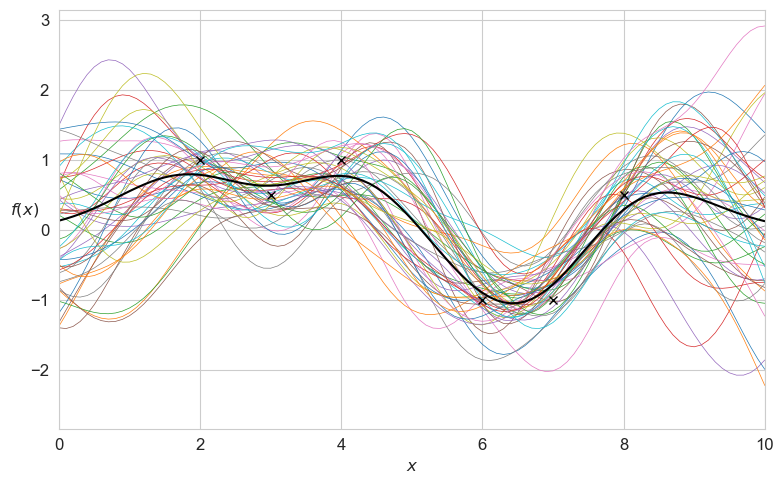

In [10]:
N_gp_post = 50
sigma_n = 0.2
    
# Compute mean and covariance of the posterior predictive distribution
kernel_fun = GP_kernels.gauss
kernel_args = {'l':1.}
mu, cov = GP_predictor(X_test, X_train, Y_train,
                       kernel_fun, kernel_args, sigma_n)
# Generate samples from the prior
gp_post = np.random.multivariate_normal(mu.flatten(), cov, N_gp_post).T

# Draw samples from the prior
plt.figure(figsize=(8, 5))
plot_GP(X_test, mu, cov, x_train_i, y_train_i, gp_post)
plt.tight_layout()
plt.show()

---

## Источники

1. *Воронцов К.В.* [Математические методы обучения по прецедентам (теория обучения машин)](http://www.machinelearning.ru/wiki/images/6/6d/Voron-ML-1.pdf). &mdash; 141 c.
1. *Roelants P.* [Understanding Gaussian processes](https://peterroelants.github.io/posts/gaussian-process-tutorial/).
1. *Krasser M.* [Gaussian processes](http://krasserm.github.io/2018/03/19/gaussian-processes/).
1. *Зайцев А.А.* Методы построения регрессионных моделей разнородных источников данных для индустриальной инженерии // Диссертация на соискание учёной степени кандидата физико-математических наук. ИППИ РАН, 2017. 148 с.

In [11]:
# Versions used
print('Python: {}.{}.{}'.format(*sys.version_info[:3]))
print('numpy: {}'.format(np.__version__))
print('matplotlib: {}'.format(matplotlib.__version__))
print('seaborn: {}'.format(seaborn.__version__))

Python: 3.7.16
numpy: 1.20.3
matplotlib: 3.5.1
seaborn: 0.12.2
